<a href="https://colab.research.google.com/github/javierortuno1/pytorch-step-by-step/blob/main/Chapter04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 4

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)
except ModuleNotFoundError:
    pass

from config import *
config_chapter4()
# This is needed to render the plots in this chapter
from plots.chapter4 import *

Finished!


In [3]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms.v2 import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize, ToImage, ToDtype

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from data_generation.image_classification import generate_dataset
from stepbystep.v0 import StepByStep
from plots.chapter4 import *

# Classifying Images

## Data Generation

In [4]:
images, labels = generate_dataset(img_size=5, n_images=300, binary=True, seed=13)

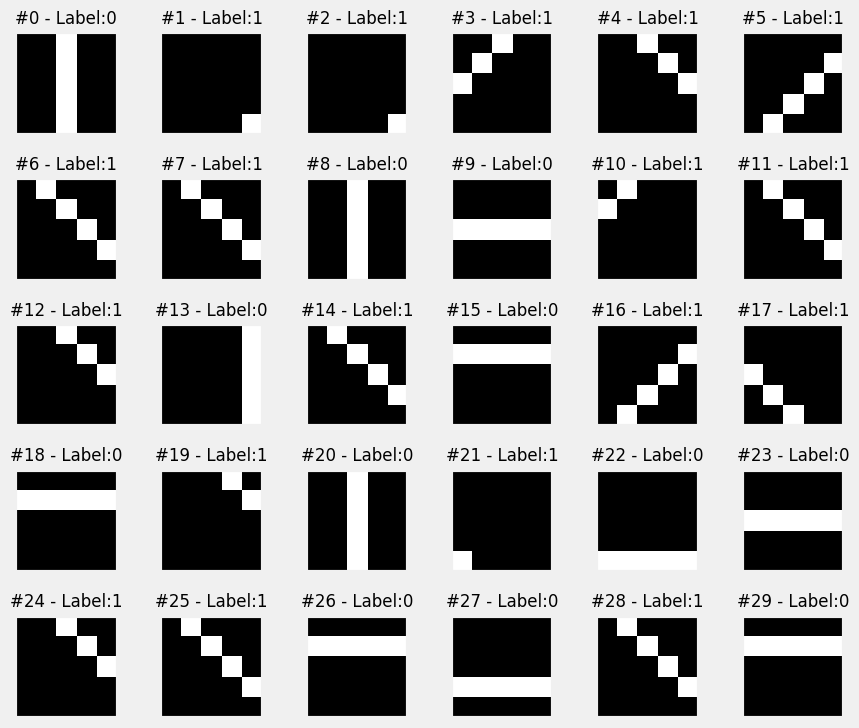

In [5]:
fig = plot_images(images, labels, n_plot=30)

## Images and Channels

Images can be represented as tensor. Let's see how it works

In [5]:
 # Each image is five-by-five pixels and is represented by a five-by-five matrix
 # It is a two-dimensional representation, which means it is a single-channel image.
 # Moreover, its dtype is np.uint8, which only accepts values from zero to 255. Uint represents unsigned integer 8bit -> 2^8 = 256 values

 # Each channel represents the intensity of a particular color or type of information
image_r  = np.zeros((5, 5), dtype=np.uint8)     # Red Channel
image_r[:, 0] = 255
image_r[:, 1] = 128

image_g = np.zeros((5, 5), dtype=np.uint8)     # Green Channel
image_g[:, 1] = 128
image_g[:, 2] = 255
image_g[:, 3] = 128

image_b = np.zeros((5, 5), dtype=np.uint8)    # Blue Channel
image_b[:, 3] = 128
image_b[:, 4] = 255

Image with one channel, it is a grayscale image

The range of pixel values goes from zero(black) to 255(white), and everything in between is a shade of gray. Therefore each pixel is an intensity value of one pice of information

In [6]:
image_gray = .2126*image_r + .7152*image_g + .0722*image_b       # From RGB to grayscale. Using the Weights (Level of importance or heaviness in the final result)

We can see each pixel or the whole image as a box, where the box can be measured as

1. Height (up/down) - axis 0
2. Width (left/right) - axis 1
3. Depth (front/back) - axis 2

Each color (r,g,b) is like a sheet of paper

Different axis values would be like:

* axis=0: stacking sheets vertically (height)
* axis=1: placing sheets side by side (width)
* axis=2: placing sheets behind each other (depth)

It's similar to how old cartoons were made - they would stack transparent sheets with different parts of the image to create the complete picture!

In [7]:
image_rgb = np.stack([image_r, image_g, image_b], axis=2) # By stacking the images in front of each then we will have 3 channels because now the whole image and each pixel
                                                          # has 3 levels of information aka 3 channels, one for each color: red, green, and blue, in that order

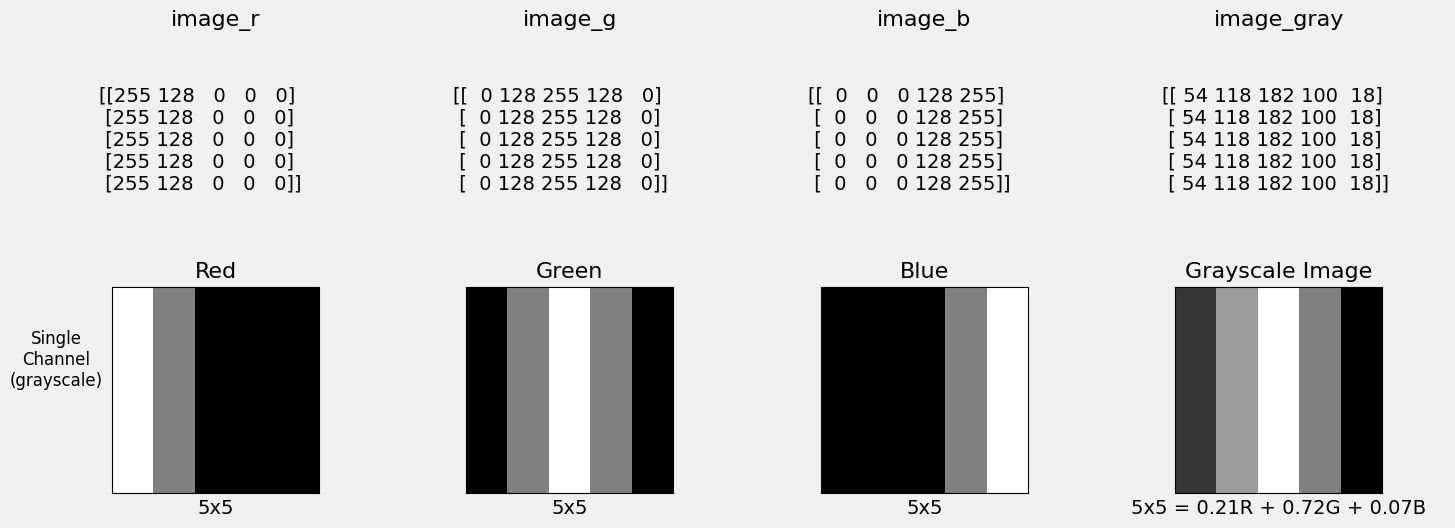

In [9]:
fig = image_channels(image_r, image_g, image_b, image_rgb, image_gray, rows=(0, 1))

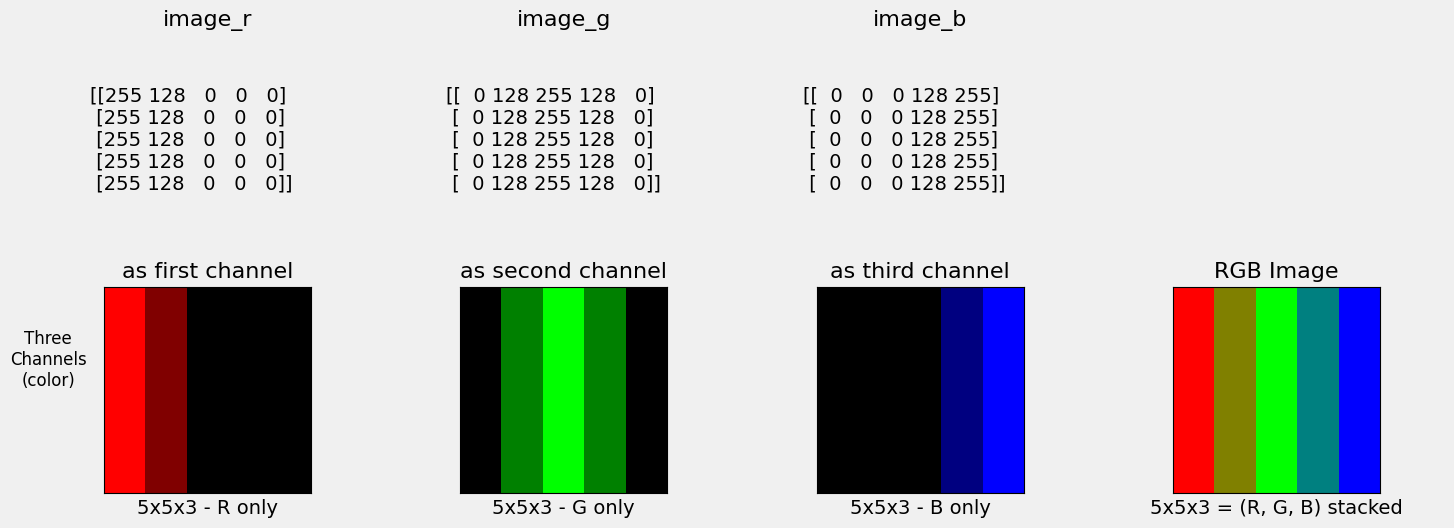

In [11]:
fig = image_channels(image_r, image_g, image_b, image_rgb, image_gray, rows=(0, 2))

### NCHW vs NHWC

Different conventions for the shape of the images

* N: # of images (in a mini-batch, for instance)
* C: # of channels (or filters) in each image
* H: stands for each Image's Height
* W: stands for each Image's Width

Thus the acronyms indicate the expected shape of the mini-batch:

* NCHW: (number of images, channels, height, width) used by Pytorch
* NHWC: (number of images, height, width, channels)

In [8]:
images.shape  # therefore the images will have a specific dimension
# 300 images
# 1 channel or filter (Level of information)
# 5 pixels of height
# 5 pixels of width

(300, 1, 5, 5)

In [9]:
example = images[7]           # We can see the diagonal line of values equal to 255, representing white pixels
example

array([[[  0, 255,   0,   0,   0],
        [  0,   0, 255,   0,   0],
        [  0,   0,   0, 255,   0],
        [  0,   0,   0,   0, 255],
        [  0,   0,   0,   0,   0]]], dtype=uint8)

In [10]:
print(example.shape)
example_hwc = np.transpose(example, (1, 2, 0)) # transpose the first dimension to become the last
example_hwc.shape

(1, 5, 5)


(5, 5, 1)

In [18]:
example_hwc

array([[[  0],
        [255],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [255],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [255],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [255]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0]]], dtype=uint8)

## Torchvision

Is a Pytorch Package containing popular:

* Datasets (MNIST, ImageNET, CIFAR, etc)
* Model architectures (with and without their pre-trained weights. such as AlexNet, VGG, ResNet)
* and Common image transformations for computer vision

If we want to use one particular dataset (not from the library) we need to use ImageFolder. This is not a dataset itself, but a generic dataset that you can use with your own images

### Transforms

They are operations that:

- **Modify** the images in someway
- OR **Convert** the image in some format

**ToImage**() convert a PIL image or Numpy array into a tensor of pixels preserving the original pixels. The pixel values are unchanged

In [13]:
print(example_hwc.shape)                    # shape (5,5,1)
image_tensor = ToImage()(example_hwc)       # Converts to tensor.. well it is a tensor but with a wrappet of image
image_tensor, image_tensor.shape            # shape (1,5,5) -> still 3D but now in the format 1Channel, 5high, 5wide = one box with only one sheet of paper

(5, 5, 1)


(Image([[[  0, 255,   0,   0,   0],
         [  0,   0, 255,   0,   0],
         [  0,   0,   0, 255,   0],
         [  0,   0,   0,   0, 255],
         [  0,   0,   0,   0,   0]]], dtype=torch.uint8, ),
 torch.Size([1, 5, 5]))

In [12]:
isinstance(image_tensor, torch.Tensor)

True

**ToDtype()** changes the data type but preserve the range

The range is kept 0-255 with scale = False but the values can support decimals therefore more details in the pixel intensity (case of float32)

The range is truncated with scale = True and the values are adapted to the format

***Scalling*** helps training NN by giving a common measure or unit Example:

````
# Without scaling:
pixel1 = 255  # bright pixel
pixel2 = 1    # dark pixel
difference = 254  # very large difference to handle

# With scaling:
pixel1 = 1.0   # bright pixel
pixel2 = 0.004 # dark pixel
difference = 0.996  # more manageable difference
````

* Neural networks learn by adjusting their weights
* If some inputs are much larger (like 255) than others (like 0.5), the network has to work harder to balance these different scales
* With all values between 0-1, the network can make more stable and consistent adjustments

In [18]:
example_tensor = ToDtype(torch.float32, scale=True)(image_tensor)
example_tensor

Image([[[0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]]], )

Compose- > is a class that composes serveral Transforms together creating a pipeline

the Compose class has a function _ _ call _ _

def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

Therefore this Function can be invoked behaving the instance as function that can store state "Function with memory"

In [8]:
# Higher-order function or factory function
def ToTensor():
    # This creates and returns a Compose object with two transforms
    # NO INPUT ARGUMENT HERE
    return Compose([ToImage(), ToDtype(torch.float32, scale=True)]) # Return an object that behaves as a function becasse it has __call__ function

tensorizer = ToTensor()                     # This creates a Compose object that has two transforms ready to be used. No image is processed yet.
                                            # The Compose object is like a pipeline waiting for input
example_tensor = tensorizer(example_hwc)    # Compose.__call__ (self, img) there fore the image is processed and transform through the pipeline
example_tensor

NameError: name 'example_hwc' is not defined

In [22]:
example_img = ToPILImage()(example_tensor)
print(type(example_img))

<class 'PIL.Image.Image'>


PIL Image will allow us to visualize the image

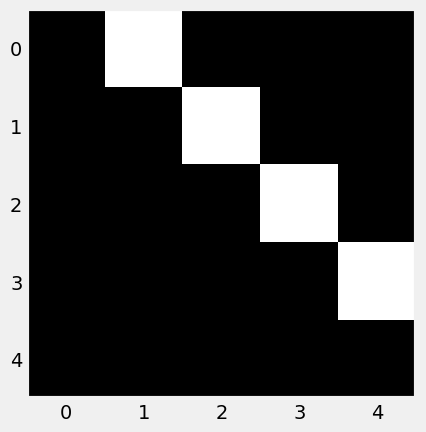

In [23]:
plt.imshow(example_img, cmap='gray')
plt.grid(False)

### Transforms on Images (Transform by modifying the image)

These transforms include the typical things you'd like to do with an image for the purpose of data augmentation (create more datpoints from the same dataset)

+ Resize()
+ CenterCrop()
+ GrayScale()
+ RandomHorizontalFlip()
+ RandomRotation()
+ ...



In [24]:
flipper = RandomHorizontalFlip(p=1.0)       # p=1.0 means always flip
flipped_img = flipper(example_img)

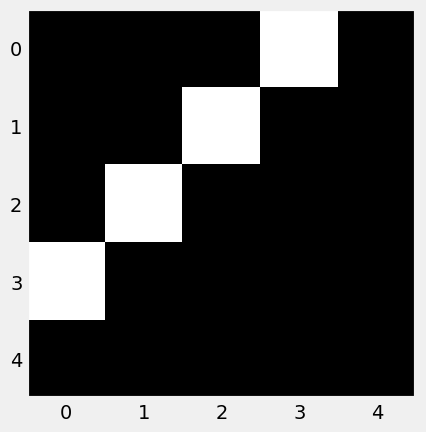

In [25]:
plt.imshow(flipped_img, cmap='gray')
plt.grid(False)

### Tensor-only Transforms (Transform by converting the format)

Some Transforms take only tensors as inputs such as LinearTransformation(), Normalize(), RandomErasing() and even ToDtype()

In [26]:
img_tensor = tensorizer(flipped_img)
img_tensor

Image([[[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]], )

#### Normalize Transform

$$
\Large
\begin{aligned}
\text{input} = 0 \implies \frac{0 - \text{mean}}{\text{std}}= \frac{0 - 0.5}{0.5}&=-1
\\
\text{input} = 1 \implies \frac{1 - \text{mean}}{\text{std}}= \frac{1 - 0.5}{0.5}&=1
\end{aligned}
$$

In [27]:
normalizer = Normalize(mean=(.5,), std=(.5,)) # Is abput standarizing the values to a certain symetrical range. It will be easier for the NN
normalized_tensor = normalizer(img_tensor)    # it create a new object and passig the image as argument
normalized_tensor

Image([[[-1., -1., -1.,  1., -1.],
        [-1., -1.,  1., -1., -1.],
        [-1.,  1., -1., -1., -1.],
        [ 1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1.]]], )

### Composing Transforms

Composing or defining a pipeline of transforms where the image will flow

In [28]:
composer = Compose([RandomHorizontalFlip(p=1.0),
                    Normalize(mean=(.5,), std=(.5,))])

In [30]:
composed_tensor = composer(example_tensor)
print(composed_tensor)
(composed_tensor == normalized_tensor).all()

Image([[[-1., -1., -1.,  1., -1.],
        [-1., -1.,  1., -1., -1.],
        [-1.,  1., -1., -1., -1.],
        [ 1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1.]]], )


tensor(True)

In [31]:
print(example)
print(example_tensor)

[[[  0 255   0   0   0]
  [  0   0 255   0   0]
  [  0   0   0 255   0]
  [  0   0   0   0 255]
  [  0   0   0   0   0]]]
Image([[[0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]]], )


Remeber that sclaing is by diving the number between the total of values accepted

In [35]:
example_tensor = torch.as_tensor(example / 255).float()
print(example_tensor)

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])


## Data Preparation

We need to convert our features and labels from Numpy arrays to Pytorch tensors:

In [41]:
# images, labels = generate_dataset(img_size=5, n_images=300, binary=True, seed=13)

In [9]:
print(images.shape) # NCHW
print(labels.shape)
print(type(images))

(300, 1, 5, 5)
(300,)
<class 'numpy.ndarray'>


Where for the 300 images, each image has a dimension of 5x5 (is square) containing the pixels where each pixel only has one level of infomation (1 Channel). Therefore in this square or sheet we have 5x5 = 25 elements. Those elements are considered as features beacuse the Network is preapred for reading features

and the labels are per image or per 5x5 object

In [7]:
# Builds tensors from numpy arrays BEFORE split and scaling the inputs to 0-1
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

print(x_tensor.shape, type(x_tensor))
print(y_tensor.shape, type(y_tensor))

torch.Size([300, 1, 5, 5]) <class 'torch.Tensor'>
torch.Size([300, 1]) <class 'torch.Tensor'>


In [ ]:
print(labels)

### Dataset Transforms

we use both tensors (x_tensor, y_tensor) to build a Dataset, but not a simple TensorDataset. We'll build our own custom dataset that is capable of handling transformations

In this way we can have transformations on-the-fly meaning that a new fresh transformation will be applied everytime the model gets new inputs

In [5]:
class TransformedTensorDataset(Dataset):            # Inheriting from Dataset

    # It takes three arguments:
    # - A tensor for feautres (x) or the inputs containing 300 samples, 1 channel and 5x5 image containers with 25 pixels
    # - A tensor for labels (y) associated labels to those 300 samples
    # - Optinal transform or transforms pipeline
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        x = self.x[index]

        if self.transform:
            x = self.transform(x)               # Image is processed by the transfomrs pipeline

        return x, self.y[index]

    def __len__(self):
        return len(self.x)

In [12]:
composer = Compose([RandomHorizontalFlip(p=0.5),
                    Normalize(mean=(.5,), std=(.5,))])          # Pipeline of Transforms

dataset = TransformedTensorDataset(x_tensor, y_tensor, transform=composer)

In [59]:
print(type(dataset), len(dataset))

<class '__main__.TransformedTensorDataset'> 300


### Let's work with our data by shuffeling, augmenting and spliting it

### SubsetRandomSampler (Using Sampler but no Augmentation in the Training set)

A Sample Decides which data points to pick from your dataset and determines the order in which they're selected

So far we have the dataset already with the transforms pipeline, now we need to split the dataset as usual.

A Sampler can be used to return sequences of indices to be used for data loading. Therefore, those indices are used to load data from a dataset

Since we need two list of indices one for the training set and one for validation set

Because instead of splitting the actual data, we split indices and from those indices we obtain the data. This is simpler since we do not have to copy the objects. Once the indices are separated we only have to load the data

### Helper Function #4

In [6]:
# n: number of data points to generate indices for
# splits: a list of values representing the relative weights (Relative = Percentage, weights = level of importance) of the split sizes (set)
# seed: A random seed to ensure reproducibility
def index_splitter(n, splits, seed=13):
    # Creates a tensor of indices from 0 to n-1
    idx = torch.arange(n)
    # Makes the split argument a tensor
    splits_tensor = torch.as_tensor(splits)   # Example: Convert [80, 20] to tensor). Beacuse Tensor operations are faster and can use GPU
    total = splits_tensor.sum().float()
    # If the total does not add up to one
    # divide every number by the total
    # THIS NORMALIZATION IS NEEDED if the split list contains raw numbers and not the relative weights
    if not total.isclose(torch.ones(1)[0]):             # Example [80,20] -> [0.8, 0.2]
        splits_tensor = splits_tensor / total
    # Uses PyTorch random_split to split the indices
    torch.manual_seed(seed)
    return random_split(idx, splits_tensor)

In [8]:
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
train_idx # Subset object

In [63]:
train_idx.indices

[118,
 170,
 148,
 239,
 226,
 146,
 168,
 195,
 6,
 180,
 157,
 2,
 160,
 66,
 46,
 276,
 126,
 212,
 119,
 77,
 53,
 237,
 252,
 202,
 200,
 289,
 135,
 186,
 231,
 211,
 35,
 293,
 229,
 265,
 256,
 134,
 191,
 214,
 8,
 83,
 150,
 190,
 208,
 209,
 275,
 60,
 295,
 142,
 251,
 176,
 260,
 3,
 31,
 0,
 137,
 20,
 81,
 287,
 181,
 129,
 166,
 97,
 110,
 206,
 267,
 241,
 109,
 177,
 27,
 52,
 43,
 245,
 247,
 141,
 68,
 131,
 217,
 78,
 185,
 49,
 96,
 14,
 111,
 234,
 284,
 263,
 269,
 101,
 32,
 285,
 79,
 297,
 94,
 85,
 11,
 5,
 80,
 165,
 183,
 4,
 33,
 100,
 73,
 235,
 277,
 16,
 144,
 132,
 167,
 130,
 45,
 48,
 201,
 99,
 34,
 138,
 178,
 244,
 225,
 173,
 95,
 22,
 197,
 174,
 90,
 223,
 274,
 92,
 279,
 19,
 74,
 28,
 162,
 133,
 151,
 37,
 299,
 18,
 203,
 13,
 156,
 268,
 259,
 116,
 70,
 71,
 230,
 108,
 238,
 47,
 163,
 30,
 188,
 64,
 216,
 121,
 187,
 72,
 221,
 258,
 44,
 179,
 272,
 159,
 253,
 280,
 140,
 120,
 62,
 271,
 57,
 1,
 149,
 9,
 29,
 194,
 158,
 115,
 1

Then the SubsetRandomSampler will provide the indices randomly but only from the provided subset. Meaning that each epoch will see all samples but in a different random order

**A Sample Decides which data points to pick from your dataset and determines the order in which they're selected**


In [15]:
# - It takes a subset of indices
# - Shuffles them randomly
# - Delievers the selected samples
train_sampler = SubsetRandomSampler(train_idx)        # Sample the indices in different orders
val_sampler = SubsetRandomSampler(val_idx)

In [67]:
print(type(train_sampler), len(train_sampler))

<class 'torch.utils.data.sampler.SubsetRandomSampler'> 240


Then we load the data to the model by mini-batches where each loading of data and therefore epoch will be based on the sampler


* Each epoch sees all training samples
* Order is randomized each epoch
* Useful for preventing the model from learning the order of samples
* Maintains the separation between train and validation sets

In [16]:
# Builds a loader of each set
train_loader = DataLoader(dataset=dataset, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(dataset=dataset, batch_size=16, sampler=val_sampler)

In [71]:
print("Number of mini-batches: Train=",len(iter(train_loader)), ", Val=",len(iter(val_loader)))

Number of mini-batches: Train= 15 , Val= 4


### Data Augmentation Transformations (No Sampler but the augmentation happens "on the fly")

The data Augmentation should happen only in the training data. The data Augmentation is accomplished using composing transforms but only augmenting some data points.

Therefore we need two composers and use them in two different datasets

In [77]:
print("Input Dataset: ",x_tensor.shape, "train_idx to be selected from the input dataset: ", len(train_idx))

Input Dataset:  torch.Size([300, 1, 5, 5]) train_idx to be selected from the input dataset:  240


In [17]:
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]      # vectorized indexing allowing to select all elements from x_tensor whose indices are in train_idx, we are extracinting the indices
y_train_tensor = y_tensor[train_idx]

print(x_train_tensor.shape, y_train_tensor.shape)

x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

print(x_val_tensor.shape, y_val_tensor.shape)

torch.Size([240, 1, 5, 5]) torch.Size([240, 1])
torch.Size([60, 1, 5, 5]) torch.Size([60, 1])


Then we add the data Augmentation via transformers only for the training set

In [18]:
# Augments the data and then scales it
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])
# Only scales the data
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

In [20]:
# Group the data points (input and outputs,features and labels, or images and classification) into a dataset.
# The datapoints should pass through a pipeline of transforms
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# We need to load the data efficiently for network consumption in each epoch for each scenario (training and validation)
# The DataLoader will get the data from 'dataset' using its __getitem__ magic function each tiems it needs a sample and here is where the transforms are applied FRESH.
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

### WeightedRandomSampler

for tackling imabalanced datasets wher we adjust the weights (level of importance) for sampling

In [22]:
classes, counts = y_train_tensor.unique(return_counts=True)
print(classes, counts) # counts:  [180, 60]  # Imbalanced! 80 samples of class 0, only 160 of class 1

tensor([0., 1.]) tensor([ 80, 160])


This Imbalance is a problem because the model might bias toward majority class

Example: If 75% of data is class 1, model might just predict 1 all the time to get 75% accuracy

And the minority class gets overlooked

Therefore we can set the weights (level of importance) for the sampler (responsible of picking the samples from the dataset). In this way the sample will pick balanced sets based on the level of importance because:

* Minority class samples get picked more often
* Balances the training process
* Model sees both classes equally

In [23]:
# Calculate weights (inverse of frequency)
weights = 1.0 / counts.float()
# If counts are [80, 160]:
# weights become [1/80, 1/160] = [0.0125, 0.00625]
# Higher weight for minority class!
weights

tensor([0.0125, 0.0063])

In [26]:
# squeeze(): Removes dimensions of size 1
# If y_train_tensor shape is [240, 1], becomes [240]

# long(): Converts to integer tensor (needed for indexing)
# Converts labels to integers to use as indices

# weights[indices]: Gets weight for each label
sample_weights = weights[y_train_tensor.squeeze().long()] # We are picking values from weight using the values of y_train_tensor as indices
# y_train_tensor value -> index -> weights value
# 0 -> picks weights[0] -> 0.0056
# 1 -> picks weights[1] -> 0.0167
# 0 -> picks weights[0] -> 0.0056

print(sample_weights.shape)
print(sample_weights[:10])
print(y_train_tensor[:10].squeeze())  # We remove one dimension for comparing

torch.Size([240])
tensor([0.0063, 0.0063, 0.0063, 0.0063, 0.0063, 0.0125, 0.0063, 0.0063, 0.0063,
        0.0063])
tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1.])


In [56]:
generator = torch.Generator()

sampler = WeightedRandomSampler(
    # List of weights, one per sample
    # Higher weight = more likely to be picked
    weights=sample_weights,

    # How many samples to draw
    num_samples=len(sample_weights),        # the lenght of sample_weights will be the same as the data size (in this case the training set)

    # Random number generator for reproducibility
    generator=generator,

    # Can I reuse the same sample multiple times?
    # replacement=True allows picking same sample multiple times
    # Therefore, mini-batch can contain the same image multiple times
    replacement=True              # We are allwoing to repeat or not the samples
)

In [65]:
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [37]:
# Get iterator from DataLoader
train_iter = iter(train_loader)

# Get first batch
batch_x, batch_y = next(train_iter)

# Print shapes and labels
print("Batch shape:", batch_x.shape)  # Should be [16, 1, 5, 5]
print("Labels shape:", batch_y.shape)  # Should be [16, 1]
print("\nLabels in this batch:", batch_y.squeeze().tolist())

# To see if we have repeated samples
unique_labels, counts = batch_y.unique(return_counts=True)
print("\nLabel distribution in batch:")
for label, count in zip(unique_labels.tolist(), counts.tolist()):
    print(f"Class {label}: {count} samples")

Batch shape: torch.Size([16, 1, 5, 5])
Labels shape: torch.Size([16, 1])

Labels in this batch: [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]

Label distribution in batch:
Class 0.0: 10 samples
Class 1.0: 6 samples


### Helper Function #5

Since we have a lot of boilderplate code here, let's build a helper function to wrap it all up

In [7]:
def make_balanced_sampler(y):
    # Computes weights for compensating imbalanced classes
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    # Builds sampler with compute weights
    generator = torch.Generator()
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )
    return sampler

In [32]:
sampler = make_balanced_sampler(y_train_tensor)

### Seeds and more (seeds)

> Think of it like a science experiment - you want to control all variables except the one you're studying.

Reproducibility brings

* Same train/val split
* Same random initializations
* Same sampling order




In [68]:
train_loader.sampler.generator.manual_seed(42)
random.seed(42)

In [69]:
# Checking if we have the same amount of positive class in the train_loader. Remember that the DataLoader will be calling sampler
torch.tensor([t[1].sum() for t in iter(train_loader)]).sum()

# Total samples with replacement = len(y_train_tensor) = 240 (80 + 160)

tensor(123.)

Original distribution:
- Class 0: 80/240  = 33.3%
- Class 1: 160/240 = 66.7%

After weighted sampling:
- Class 0: 117/240 = 48.75%
- Class 1: 123/240 = 51.25%

In [70]:
def set_seed(self, seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    try:
        self.train_loader.sampler.generator.manual_seed(seed)
    except AttributeError:
        pass

setattr(StepByStep, 'set_seed', set_seed)

### Putting It Together (Data preparation)

Big picture:

* Custom dataset to handle transforms on tensors
* HelperFunction for splitting indices
* HelperFunction for building a weighted random sampler

* Processing Data prepration
  - Scaling pixel values from [0, 255] to [0, 1]
  - Splitting indices and tensors into training and validation sets
  - Building composed transforms, including data augmentation in the training set
  - Using a custom dataset to apply transforms to tensors
  - WeightedRandomSampler to handle class imbalance
  - DataLoaders, using sampler together with thre training set

Javi's big picture:

- Data generation
    - Generation of custom images using arrays
- Data Preparation
    - Build the tensors from the numpy arrays and scaling the inputs
        ``````
        x_tensor = torch.as_tensor(images / 255).float()
        y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()
        ``````
    - Class for defining a custom Dataset with data points able to allow transform operations
        > class TransformedTensorDataset(Dataset)
    - Compose or build the transform pipeline
- Data Preparation Samplers and augmented training set on the fly
    - Sampler: Process for picking data points from a data set
        - SubsetRandomSampler: based on a subset indices we can get random elements from the dataset. We will need the dataLoader without shuffle and with sampler argument
        - WeightedRandomSampler: For imbalanced labels we can increase the weight or level of importance for the minority class allowing the sampler to pick up samples toward the minority class and balancing therefore the kind of samples in the training and validation set.  We will need the dataLoader without shuffle and with sampler argument
    - Augmentation: based on transforms we can perform operations over the data points tensors and then using the TransformedTensorDataset and then a dataLoader with shuffle but no sampler
- Seed and reproducibility
    - It allows to have same train/val split even the sampling order for analysing and training the Network in a certain way. Like a stable room or space

In [8]:
#### DATA PREPARATION #####

# TO TENSORS
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

# INDICES FOR SPLITTING DATA
# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])

# TENSORS SPLITTED
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# TRANSFORMS PIPELINES
# Builds different composers because of data augmentation on training set
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

# APPLY TRANSFORM PIPELINES TO CUSTOM DATASET
# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# BALANCED SAMPLER (PICK UP PROCESS)
# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# LOAD THE DATA TO BE DIGGESTED
# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

### Pixels as Features

Where each element of the 5x5 container (Image) is a pixel with a level of information (channel). These pixels with their channel intensity can be seen as the features of a FFN.

In [12]:
dummy_xs, dummy_ys = next(iter(train_loader)) # We fetch one mini-batch of images from out training set
dummy_xs.shape              # 16 images, one channel each image, dimensions five-by-five pixels

torch.Size([16, 1, 5, 5])

In [12]:
flattener = nn.Flatten()
dummy_xs_flat = flattener(dummy_xs)       # We collapse the dimensions of channel and image size => we collapse them to 1 vector

print(dummy_xs_flat.shape)
print(dummy_xs_flat[0])               # First element of the mini-batch

torch.Size([16, 25])
tensor([-1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1.,
        -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1.])


If we have three channels then we have

- the HxW = number of pixels
- And since we have three level of information (Sheet of paper) then:
    - redHxredW + greenHxgreenW + blueHxblueW = rgb_or_numberChannels * (HxW)


After the flattern we will get a tensor with

[16, 25]. It means 16 samples where each sample (image in this case) has 25 pixels per channel. it means that our flattern tensor has 16 rows and 25 columns or features, therefore each row is an image with 25 features

We need this flattern because the linear layer always expect a 2D input where each row is a sample and each column is a feature.

Hence we will need CNN because they keep the spatial structure (5x5 grid) where we can identify patterns and then the output of that CNN will identify what those patterns mean for the labels by using a FFN which demand 2D Inputs

## Shallow Model

simple neural network with very few layers - typically just one layer between input and output. Therefore, it can be seen as a logistic regression since it only has one activation function also known as no-linear function


In this case we have flattern output that results in an input with 25 features and 16 samples. Where each feature represents a pixel in a given channel.

The Model will first fit alinear regression such that its outputs are logits(z) which are converted into probabilities using a sigmoid function

Therefore the linear regression part is just weighted sum, where each feature (aka pixel for a given channel) will have a certain level of importance that will be represented as the appropiate weight (trainable variable).

The combination of weights with features plus the bias will be proximate or equal to the target value. And that is the task of the model to find the appropiate weights and biases that approximate better to the ground truth

$$
\Large \text{P}(y=1) = \sigma(z) = \sigma(w_0x_0+w_1x_1+\cdots+w_{24}x_{24})
$$

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/classification.png?raw=1)

### Notation

$$
\Large W =
\underset{(25 \times 1)}{
\begin{bmatrix}
w_0 \\
w_1 \\
\vdots \\
w_{24}
\end{bmatrix}};
X =
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{24}
\end{bmatrix}}
$$

$$
\Large
\begin{aligned}
z
& = W^T \cdot X
=\underset{(1 \times 25)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{24}
\end{bmatrix}}
=
\underset{(1 \times 25)}{
\begin{bmatrix}
w_0 & w_1 & \cdots & w_{24}
\end{bmatrix}}
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
& = w_0x_0 + w_1x_1 + \cdots + w_{24}x_{24}
\end{aligned}
$$

### Model Configuration (Definition of the Model, loss function, and optimizer)

In [27]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_logistic = nn.Sequential()
model_logistic.add_module('flatten', nn.Flatten())
model_logistic.add_module('output', nn.Linear(25, 1, bias=False))       # 25 features as inputs and 1 Unit/neuron and therefore one output
model_logistic.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
optimizer_logistic = optim.SGD(model_logistic.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

### Model Training

In [14]:
!cat stepbystep/v0.py


import numpy as np
import datetime
import torch
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

plt.style.use('fivethirtyeight')

class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        
        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses =

In [28]:
n_epochs = 100

sbs_logistic = StepByStep(model_logistic, binary_loss_fn, optimizer_logistic) # We init the model with the configs
sbs_logistic.set_loaders(train_loader, val_loader)   # We set the loaders allwoing the model to digest better the input/features
sbs_logistic.train(n_epochs)                         # Training using the num of epochs and the state of the model

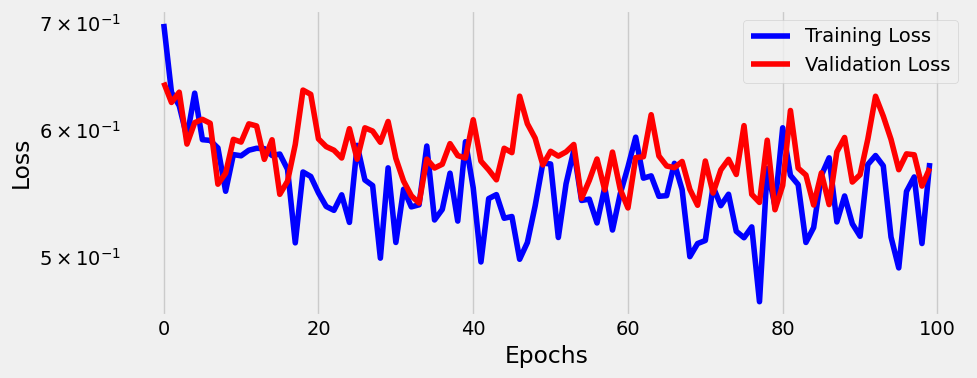

In [16]:
fig = sbs_logistic.plot_losses()

It seems our model is barely learning anything! because the losses are horrible and it means that the weights are not in control of the model.

This is because the model has only a straight line as tool for classifying the data and unfortunatelly this is not possible with straight lines, and the sigmoid function even as non-linear is not processing the deccision is just scaling it but still with no power to influence the deccision boundry

Scenarios where shallow models excel:

- Simple binary classification
- When data is linearly separable
- Text classification with simple features
- Spam detection
- Credit approval (based on numerical features)
- Medical screening with clear risk factors

## Deep-ish Model

Let's just add layers and tehrefore a better processing of the data

Lets add a flattern layer for the input layer and 2 hidden layers as Linear layers before reaching the already existing output layer

remember that 'z' is the output of the linear regression (weighted sum) in othere words the result of the previous output

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/classification_equiv.png?raw=1)

I. Forward pass

 1. An **image** is **flattened** to a tensor with **25 features**, from x0 to x24 (not depicted in the figure above)
 2. The **25 features** are **forwarded** to **each** of the five **unit** in **Hidden Layer #0**
 3. Each **unit** in Hidden Layer #0 **use** its **weights**, from w00 to w04, a**nd the features** from the Input Layer to **compute** its corresponding **outputs**, from z00 to z04
 4. The **outputs** of **Hidden Layer #0**, from z00 to z04, are **forwarded** to each of the three **units** in **Hidden Layer #1** (in a way, the **outputs** of Hidden **Layer #0 **work **as** if they were **features** **to** **Hidden Layer #1**)
 5. Each **unit in Hidden Layer #1** use its **weights**, from w10 to w12, and the **z0 values** from the **preceding** hidden **layer** to **compute** its corresponding **outputs**, from z10 to z12
 6. The outputs of the Hidden Layer #1 are forwarded to the single unit in the output layer (again, the outputs of Hidden Layer #1 work as if they were features to the output Layer)
 7. The unit in the Output Layer uses its weights (w20) and the z1 values from the preceding hidden layer to compute its corresponding output (z2)
 8. z2 is a logit, which is converted to a probability using a sigmoid function

### Model Configuration

In [10]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_nn = nn.Sequential()
model_nn.add_module('flatten', nn.Flatten())
model_nn.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_nn.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_nn.add_module('output', nn.Linear(3, 1, bias=False))
model_nn.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
optimizer_nn = optim.SGD(model_nn.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

### Model Training

In [26]:
n_epochs = 100

sbs_nn = StepByStep(model_nn, binary_loss_fn, optimizer_nn)
sbs_nn.set_loaders(train_loader, val_loader)
sbs_nn.train(n_epochs)

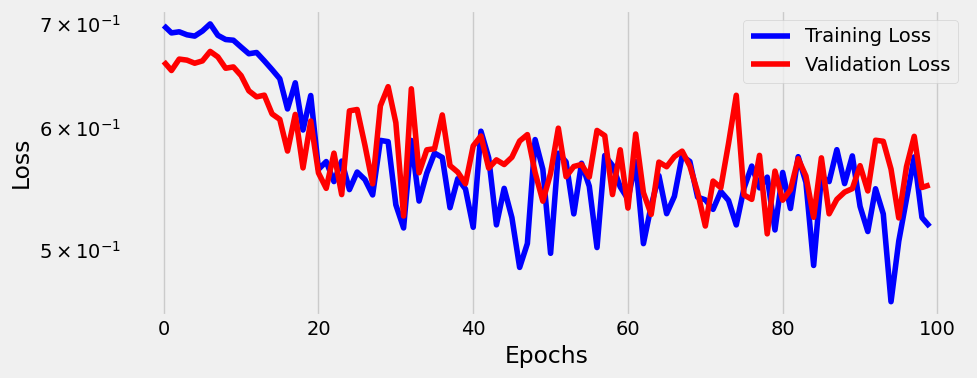

In [ ]:
fig = sbs_nn.plot_losses()

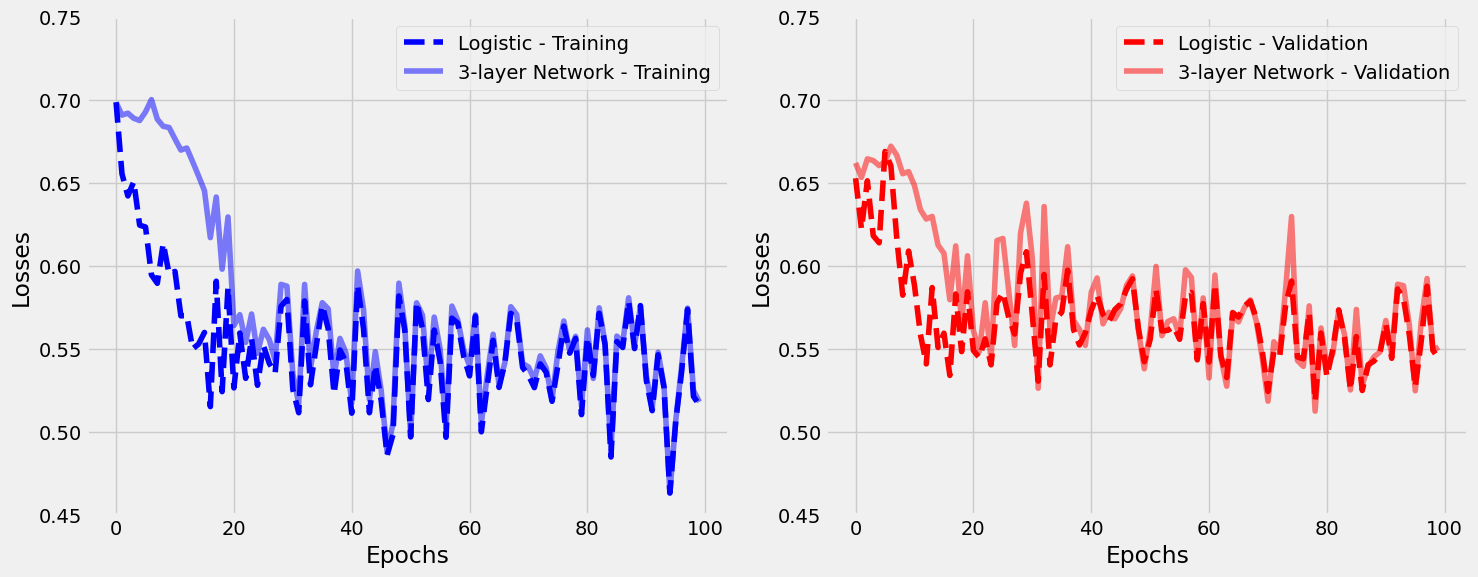

In [ ]:
fig = figure5(sbs_logistic, sbs_nn)

It seems even worse than the logistic regression but at the end it seems to converge to the same result, then it seems that they are the same. we are missing the activation functions!!

### Show Me the Math!

$$
\large
\begin{array}{rcccccccccccc}
\text{Hidden}\ \#0 & & & & & & & &
\underset{(5 \times 1)}{
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}}
&
=
&
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}
&
&
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
\text{Hidden}\ \#1 & & & &
\underset{(3 \times 1)}{
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}}
&
=
&
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}
&
&
\underset{(5 \times 1)}{
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}}
\\
\text{Output} &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}
&
\underset{(3 \times 1)}{
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}}
\\
\hline
\text{substituting } z's... &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underbrace{
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}}_{\text{Output Layer}}
&
& &
\underbrace{
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}}_{\text{Hidden Layer #1}}
& &
& &
\underbrace{
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}}_{\text{Hidden Layer #0}}
&
&
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
\text{multiplying...} & &
=
&
\underbrace{
\underset{(1 \times 25)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}}_{\text{Matrices Multiplied}}
&
& & & & & & & &
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\end{array}
$$

### Show Me the Code!

In [15]:
w_nn_hidden0 = model_nn.hidden0.weight.detach()
w_nn_hidden1 = model_nn.hidden1.weight.detach()
w_nn_output = model_nn.output.weight.detach()

w_nn_hidden0.shape, w_nn_hidden1.shape, w_nn_output.shape

(torch.Size([5, 25]), torch.Size([3, 5]), torch.Size([1, 3]))

In [16]:
w_nn_equiv = w_nn_output @ w_nn_hidden1 @ w_nn_hidden0
w_nn_equiv.shape

torch.Size([1, 25])

In [17]:
w_nn_equiv = w_nn_output.mm(w_nn_hidden1.mm(w_nn_hidden0))

In [ ]:
w_logistic_output = model_logistic.output.weight.detach()

w_logistic_output.shape

torch.Size([1, 25])

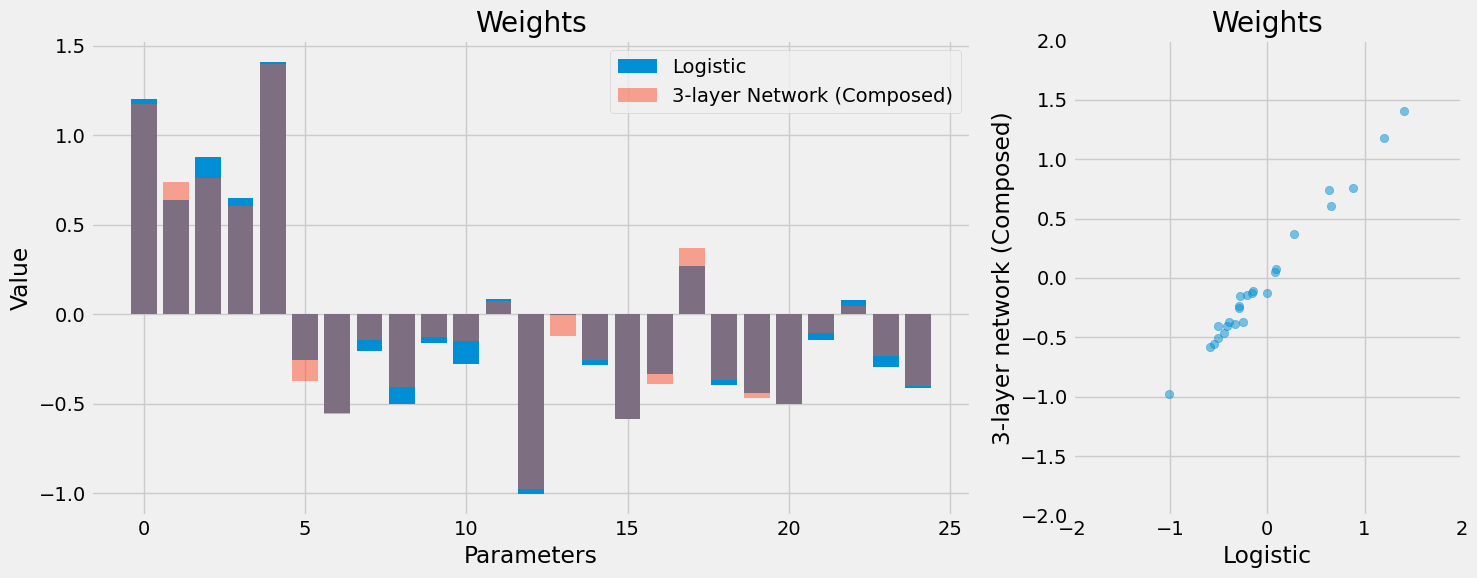

In [ ]:
fig = weights_comparison(w_logistic_output, w_nn_equiv)

In [18]:
def count_parameters(self):
    return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

setattr(StepByStep, 'count_parameters', count_parameters)

In [ ]:
sbs_logistic.count_parameters(), sbs_nn.count_parameters()

(25, 143)

### Weights as Pixels

Let's try to visualize the weights as pixels creating an image of weights or pixels

Therefore, we can start by creating a tensor with the weights used by each unit in the Hidden Layer #0. Each unit uses 25 weights since each node receives values from 25 features, since we need to compute in the linear regression and one weight by input/feature, therefore 25 weights

In [19]:
w_nn_hidden0.shape      # 5 rows as units/neurons and 25 columns as weights (one per feature) and the shape attribute reutns a tensor

torch.Size([5, 25])

We only need to adjust the dimensionality of the tensor ("unflatten") and having a 5x5 image. Then we have 5 weights per image and each weight contains 25 feaature-weights

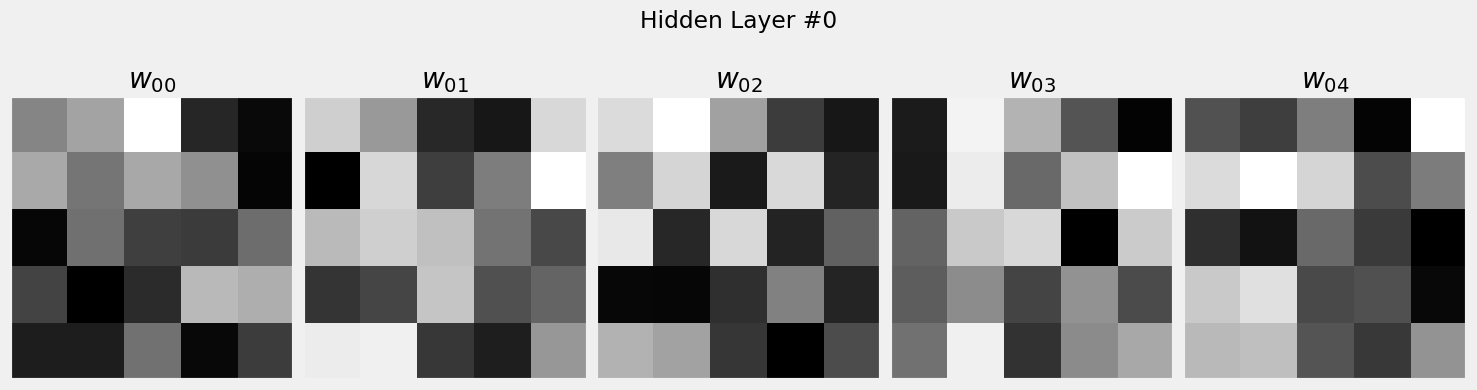

In [20]:
fig = figure7(w_nn_hidden0)

Visualizing weights as images is commonplace when using convolutional neural networks (CNNs). These images will be called filtes and trained models will likely exhibit more recognizable characteristics

In other words;

- Each image (containing 25 pixels as features) will be processed by the hidden layer #0, that contains 5 units/neurons.
- Those neurons will contain 1 weight per feature, therfore if the image is 5x5 = 25 pixels as feature, then since each neuron has to process or digest each feature, then each unit will contain 25 weights as elements
  - 1st pixel-feature * 1st weight-unit-0-hidden-0 + 2nd pixel-feature * weight-unit-0-hidden-0 ... = input-pixels-feature @ weights-unit0-hidden0 = 25-features @ 25-Weights-unit0-hidden0

Hence, we can consider the set of weights per image input as feature as new "sheet" multiply by input image "sheet", and computing to a new output imageByweight "sheet". Therefore the Weight sheet could be seen as a filter

## Activation Functions

They are nonlinear function that can either squash or bend straight lines

### Sigmoid

We use it mainly for transofrming Linear outputs of weighted sum (logits) into probabilities.

This function squashes its input values (z or logit) into the range of [0,1] 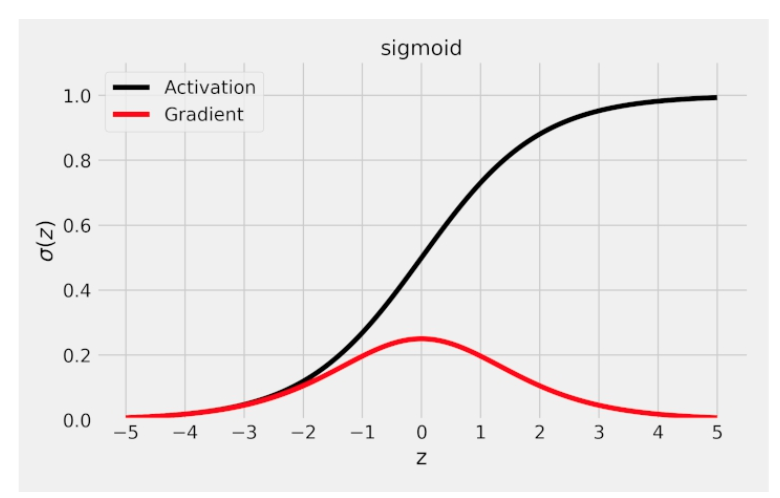

We can also check the gradient peak value that is only 0.25 for z=0 and that it gets close to zero as the absolute value of z reaches a value of five

Remember that the gradient shows how sentisitive to changes is the function or graph to the inputs (z in this case).

When z = 0:
- Sigmoid output = 0.5 (undecided)
- Gradient is highest (most sensitive)
- Small changes in input (z) cause big changes in output (sigmoid(z))
- Model learns fastest here; because it should learn a lot from this example, making bigger the weight updates.

When z is very positive (like +5):
- Sigmoid output ≈ 1 (very confident it's class 1)
- Gradient almost 0 (not sensitive)
- Even big changes in input barely change output
- Model learns very slowly; It should make smaller adjustments, making smaller weight updates

When z is very negative (like -5):
- Sigmoid output ≈ 0 (very confident it's class 0)
- Gradient almost 0 (not sensitive)
- Even big changes in input barely change output
- Model learns very slowly


Practical interpretation:

- Model learns best when it's "unsure" (z near 0)
- Model learns slowly when it's "very confident" (z far from 0)
- It's like: the more confident the model is, the harder it is to change its mind!


$$
\Large \sigma(z) = \frac{1}{1 + e^{-z}}
$$

Then, we can state:

During Backpropagation we fetch from each layer:
- How sensitive the output is to changes (gradients)
- How uncertain/confident the model is

Then The optimizer will be the behaviour of the model based on the gradients
When gradients are large (uncertain):
- Takes bigger steps
- Makes larger weight updates
- Learns faster from these examples

When gradients are small (confident):
- Takes smaller steps
- Makes tiny weight updates
- Learns slowly/carefully

It's like learning to park a car:

At first: big adjustments when far from spot (high gradients)
Near the end: tiny adjustments when almost perfect (small gradients)

This automatic adjustment of step size (through gradients) helps the optimizer find the sweet spot between:

Exploring new solutions (when uncertain)
Refining existing solutions (when confident)

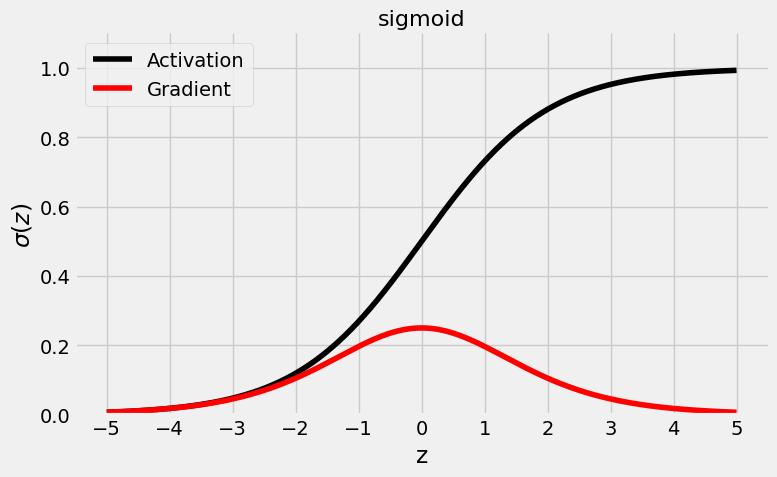

In [21]:
fig = plot_activation(torch.sigmoid)

In [23]:
dummy_z = torch.tensor([-3., 0., 3.])
torch.sigmoid(dummy_z)

tensor([0.0474, 0.5000, 0.9526])

The sigmoid can be:

- a Function torch.sigmoid()
- a Class/Model on its own nn.Sigmoid()

In [24]:
nn.Sigmoid()(dummy_z)

tensor([0.0474, 0.5000, 0.9526])

### Hyperbolic Tangent (Tanh)

The activation values (output) are already somewhat normalized inputs (inputs in a scale between a range) for the next layer

It is sesnsitive even more than the sigmoid when at its peak but it reaches confidence so fast when the z reache three or minu three

$$
\Large \sigma(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}
$$

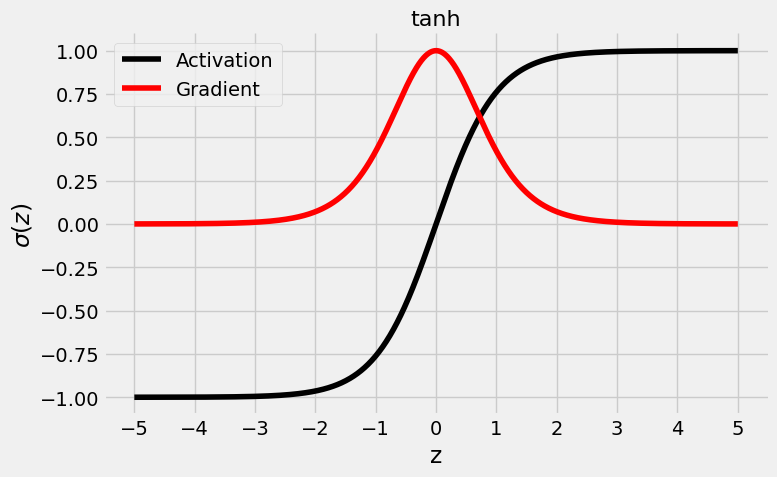

In [25]:
fig = plot_activation(torch.tanh)

In [11]:
dummy_z = torch.tensor([-3., 0., 3.])
torch.tanh(dummy_z)

tensor([-0.9951,  0.0000,  0.9951])

In [27]:
nn.Tanh()(dummy_z)

tensor([-0.9951,  0.0000,  0.9951])

### Rectified Linear Unit (ReLU)

It does not squash the values into a range, it simply preserves positive values and turns all negative values into zero.

The gradient is either one (for positive values) or zero (for negative values) no more vanishing gradients! it leads to faster convergence but it could stuck the updates of gradients because negative values will be always zero and therefore can be called "dead neurons", since the gradients will be 0 (no sensitive to changes or super confidence) and therefore the weights will not be updated by the optimizer

Key differences:

- Sigmoid/tanh: Gradients get tiny at extremes
- ReLU:
  - Positive values: Constant gradient = 1 (always learning!)
  - Negative values: Zero gradient (completely dead!)

$$
\Large
\begin{aligned}
\sigma(z) &=
\begin{cases}
z,\ \text{if } z \ge 0
\\
0,\ \text{if } z < 0
\end{cases}
\\
& \text{or}
\\
\sigma(z) &= \text{max}(0, z)
\end{aligned}
$$

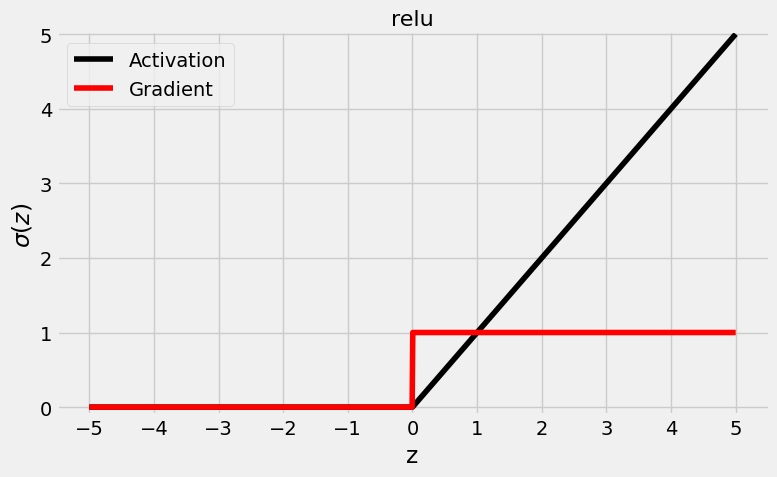

In [ ]:
fig = plot_activation(torch.relu)

In [12]:
dummy_z = torch.tensor([-3., 0., 3.])
F.relu(dummy_z)

tensor([0., 0., 3.])

In [13]:
nn.ReLU()(dummy_z)

tensor([0., 0., 3.])

In [14]:
dummy_z.clamp(min=0)          # clamp: it sets any value below a minum it will be set to that value

# min=1. -> [1, 1, 3]
# min=3. -> [3, 3, 3]
# min=4. -> [4, 4, 4]


tensor([0., 0., 3.])

### Leaky ReLU

If the problem was assigning 0 to negative values, then let's assign a tiny activation value and it will yield a tiny gradient, instead of a fixed zero.

The multiplier for negative values is called coefficient of leakage

This fact gives the neuron a chance to get unstuck

$$
\Large
\begin{aligned}
\sigma(z) =&
\begin{cases}
z,\ \text{if } z \ge 0
\\
0.01z,\ \text{if } z < 0
\end{cases}
\\
\text{or}&
\\
\sigma(z)=&\text{max}(0,z)+0.01\ \text{min}(0,z)
\end{aligned}
$$

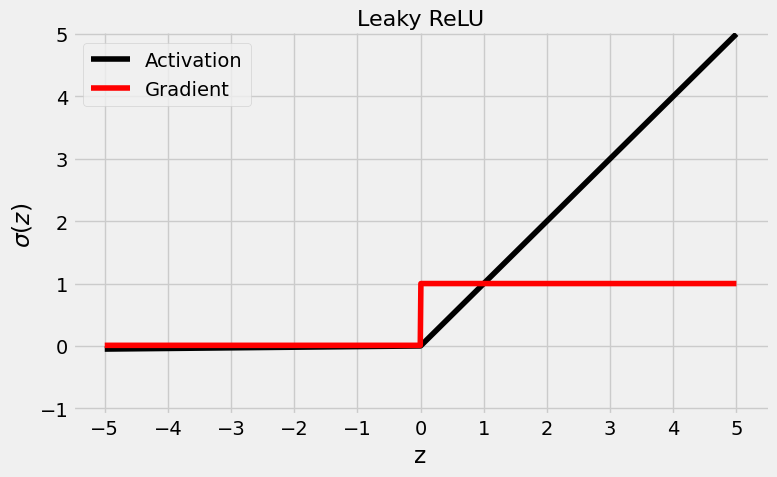

In [ ]:
fig = plot_activation(nn.LeakyReLU(), name='Leaky ReLU')

In the figure above, we can see that it is pretty much the same as the ReLU, except for the tiny, barely visible slope on the left-hand side

In [15]:
dummy_z = torch.tensor([-3., 0., 3.])
F.leaky_relu(dummy_z, negative_slope=0.01)

tensor([-0.0300,  0.0000,  3.0000])

In [16]:
nn.LeakyReLU(negative_slope=0.02)(dummy_z)

tensor([-0.0600,  0.0000,  3.0000])

May be the model can learn the coefficient too? sure it can!

### Parametric ReLU (PReLU)

The coefficinet of leakage by PReLU will allow the model to learn the parameter, instead of an arbitrary value

$$
\Large
\begin{aligned}
\sigma(z) =&
\begin{cases}
z,\ \text{if } z \ge 0
\\
az,\ \text{if } z < 0
\end{cases}
\\
\text{or}&
\\
\sigma(z)=&\text{max}(0,z)+a\ \text{min}(0,z)
\end{aligned}
$$

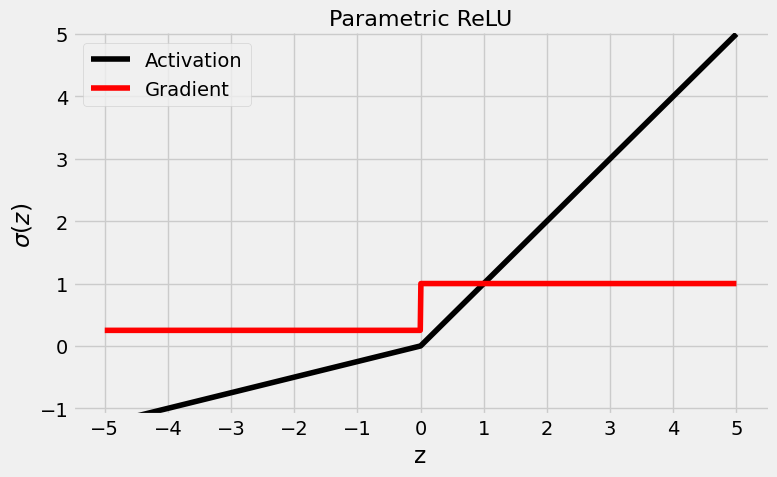

In [17]:
fig = plot_activation(nn.PReLU(), name='Parametric ReLU')

In [20]:
dummy_z = torch.tensor([-3., 0., 3.])
F.prelu(dummy_z, weight=torch.tensor(0.25))         # Here we are passing a weight

tensor([-0.7500,  0.0000,  3.0000])

In [21]:
nn.PReLU(init=0.25)(dummy_z)                        # Here we are passing an initial value and since nn.PReLU is a model then it will learn the param "grad_fn"

tensor([-0.7500,  0.0000,  3.0000], grad_fn=<PreluKernelBackward0>)

## Deep Model

Now let's add an activation function per hidden layer

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/classification_relu2.png?raw=1)

### Model Configuration

In [22]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_relu = nn.Sequential()
model_relu.add_module('flatten', nn.Flatten())
model_relu.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_relu.add_module('activation0', nn.ReLU())
model_relu.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_relu.add_module('activation1', nn.ReLU())
model_relu.add_module('output', nn.Linear(3, 1, bias=False))
model_relu.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
optimizer_relu = optim.SGD(model_relu.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

### Model Training

In [23]:
n_epochs = 50

sbs_relu = StepByStep(model_relu, binary_loss_fn, optimizer_relu)
sbs_relu.set_loaders(train_loader, val_loader)
sbs_relu.train(n_epochs)

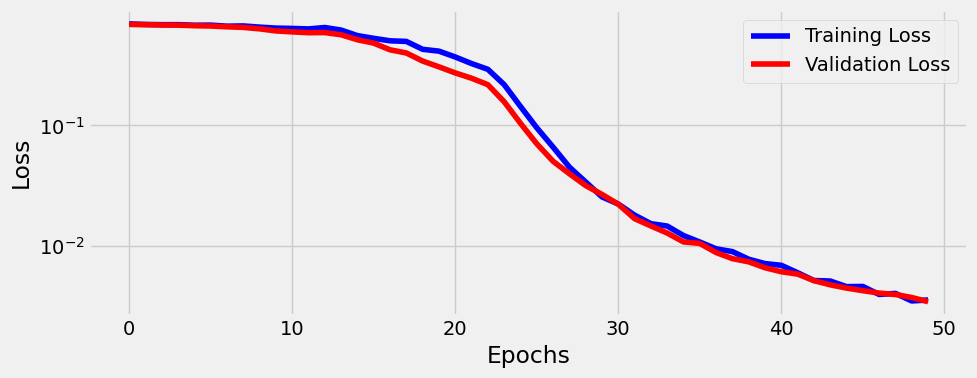

In [24]:
fig = sbs_relu.plot_losses()

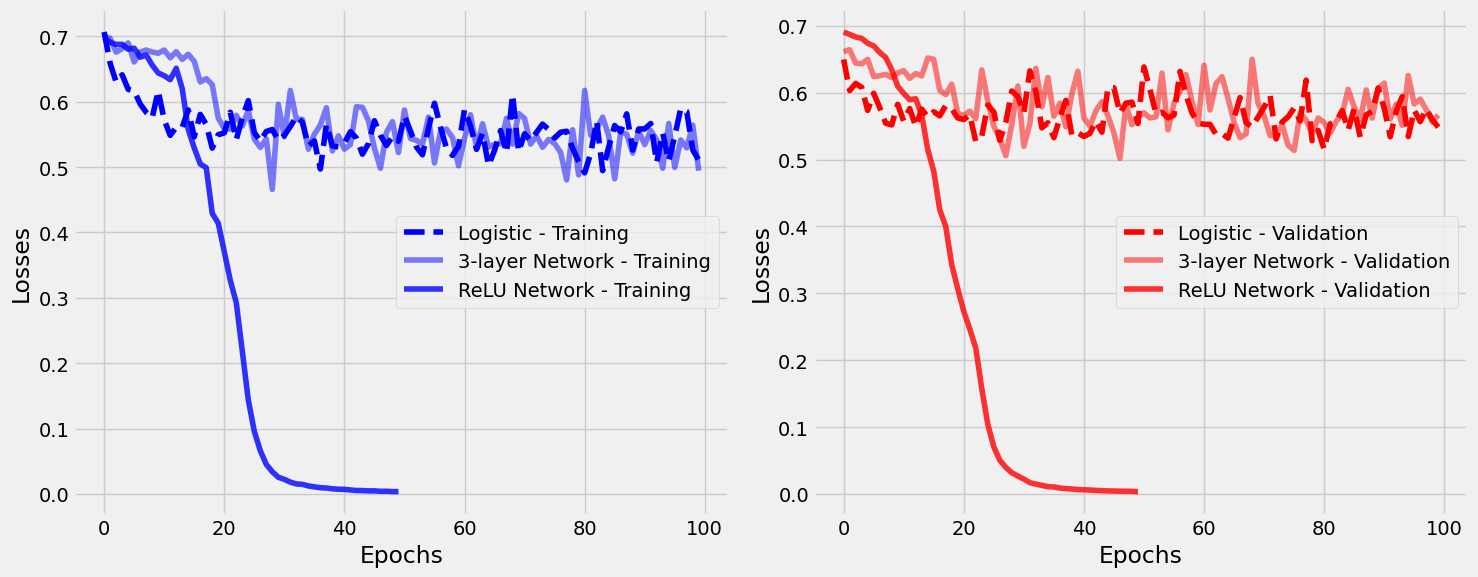

In [29]:
fig = figure5b(sbs_logistic, sbs_nn, sbs_relu)

It took only a handful of epochs for our new model to outperform the previous one. Clearly, this models is not equivalent to a logistic regression: It is much, much better.

The activation function is using a non-linear function for separating the data (images represented as pixels or features) and finding the propper relationship with the labels. The activation function can demonstrate it has found better resullts by analysing the Losses, where in each epoch the losses get lower and lower.

And by having lower losses then the backpropagation (chain of gradients) will tell the optimizer how sensitive (confindence level) is the current model about its weights, with high sesitivity it will mean uncertain and it will updatade the changes with really big changes, low sensitivity then the weights will not change to much and that is happening at the end of the epochs.

Now, those weights can fit the images associated with their labels, in this case a binary classification problem, therefore separating the data

### Show Me the Math Again!

$$
\large
\begin{array}{rcccccccccccc}
\text{Hidden }\#0 & & & & & & & &
\underset{(5 \times 1)}{
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}}
&
=
&
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}
&
&
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
\text{Hidden }\#1 & & & &
\underset{(3 \times 1)}{
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}}
&
=
&
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}
&
&
\underbrace{
f_0
\underset{(5 \times 1)}{
\left(
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}
\right)}}_{\text{Activation #0}}
\\
\text{Output} &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}
&
\underbrace{
f_1
\underset{(3 \times 1)}{
\left(
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}
\right)}}_{\text{Activation #1}}
\\
\hline
\text{substituting z's...} &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underbrace{
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}}_{\text{Output Layer}}
&
f_1
& &
\left(
\underbrace{
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}}_{\text{Hidden Layer #1}}
\right.
&
&
f_0
& &
\left(
\underbrace{
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}}_{\text{Hidden Layer #0}}
\right.
&
&
\left.
\left.
\underbrace{
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}}_{\text{Inputs}}
\right)
\right)
\end{array}
$$

## Putting It All Together

Usually we invest more time in data preparation than on actual model training (since it is automated)

In [34]:
!cat data_generation/image_classification.py

import numpy as np


def gen_img(start, target, fill=1, img_size=10):
    # Generates empty image
    img = np.zeros((img_size, img_size), dtype=float)

    start_row, start_col = None, None

    if start > 0:
        start_row = start
    else:
        start_col = np.abs(start)

    if target == 0:
        if start_row is None:
            img[:, start_col] = fill
        else:
            img[start_row, :] = fill
    else:
        if start_col == 0:
            start_col = 1
        
        if target == 1:
            if start_row is not None:
                up = (range(start_row, -1, -1), 
                      range(0, start_row + 1))
            else:
                up = (range(img_size - 1, start_col - 1, -1), 
                      range(start_col, img_size))
            img[up] = fill
        else:
            if start_row is not None:
                down = (range(start_row, img_size, 1), 
                        range(0, img_size - start_row))
            else:
           

In [ ]:
# Data Generation
images, labels = generate_dataset(img_size=5, n_images=300, binary=True, seed=13)

In [30]:
# Allowing Custom Dataset to be transform
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        x = self.x[index]

        if self.transform:
            x = self.transform(x)

        return x, self.y[index]

    def __len__(self):
        return len(self.x)

In [35]:
# Spliting the dataset via its indices
def index_splitter(n, splits, seed=13):
    idx = torch.arange(n)
    # Makes the split argument a tensor
    splits_tensor = torch.as_tensor(splits)
    total = splits_tensor.sum().float()
    # If the total does not add up to one
    # divide every number by the total
    if not total.isclose(torch.ones(1)[0]):
        splits_tensor = splits_tensor / total
    # Uses PyTorch random_split to split the indices
    torch.manual_seed(seed)
    return random_split(idx, splits_tensor)

In [36]:
# Use the sampler (how to pick up values from the dataset) based on the weights (level of importance) toward the minority for a balance of classes
# when having the training and validation sets
def make_balanced_sampler(y):
    # Computes weights for compensating imbalanced classes
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    # Builds sampler with compute weights
    generator = torch.Generator()
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )
    return sampler

In [38]:
# DATA PREPARATION

# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# Builds different composers because of data augmentation on training set
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# PORTIONS FOR DIGESTING THE DATA
# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [39]:
# CONFIG THE MODEL

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(11)
# Now we can create a model
model_relu = nn.Sequential()
model_relu.add_module('flatten', nn.Flatten())
model_relu.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_relu.add_module('activation0', nn.ReLU())
model_relu.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_relu.add_module('activation1', nn.ReLU())
model_relu.add_module('output', nn.Linear(3, 1, bias=False))
model_relu.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
# (now retrieved directly from the model)
optimizer_relu = optim.SGD(model_relu.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

In [40]:
# TRAIN THE MODEL

n_epochs = 50

sbs_relu = StepByStep(model_relu, binary_loss_fn, optimizer_relu)
sbs_relu.set_loaders(train_loader, val_loader)
sbs_relu.train(n_epochs)

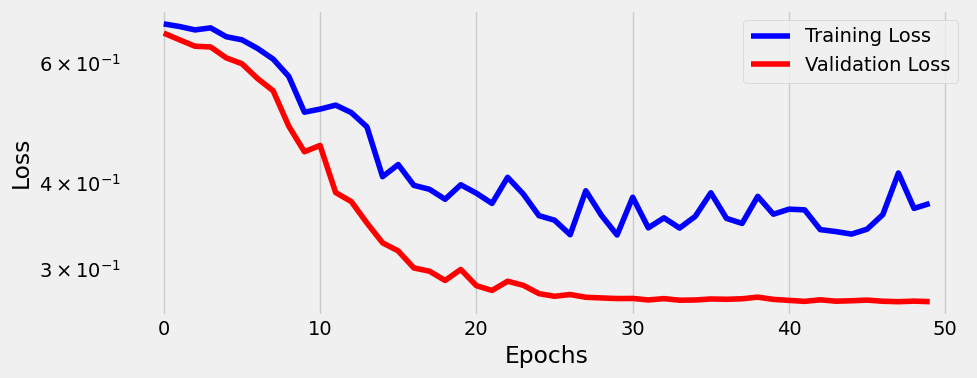

In [42]:
# Check the losses and analyse how good is the model

fig = sbs_relu.plot_losses()